# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [ ]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [ ]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [ ]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [ ]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-09-29 16:11:32--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.165.102.109, 3.165.102.96, 3.165.102.126, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.165.102.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  18.2MB/s    in 4.0s    

2025-09-29 16:11:36 (84.3 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil

In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Define paths
cell_images_dir = 'cell_images'
training_path = 'train'
testing_path = 'test'
validation_path = 'val'

In [ ]:
# Create train/validation/test directories if they don't exist
def create_directory_structure():
    for folder in [training_path, testing_path, validation_path]:
        if not os.path.exists(folder):
            os.makedirs(folder)

        # Create subdirectories for classes
        os.makedirs(os.path.join(folder, 'Parasitized'), exist_ok=True)
        os.makedirs(os.path.join(folder, 'Uninfected'), exist_ok=True)

create_directory_structure()

In [ ]:

# Organize the dataset into train/val/test splits
def organize_dataset(train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Organize the cell images into train, validation, and test sets"""

    # Check if already organized
    if len(os.listdir(os.path.join(training_path, 'Parasitized'))) > 0:
        print("Dataset already organized")
        return

    parasitized_dir = os.path.join(cell_images_dir, 'Parasitized')
    uninfected_dir = os.path.join(cell_images_dir, 'Uninfected')

    # Get all image files
    parasitized_images = [f for f in os.listdir(parasitized_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_images = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Parasitized images: {len(parasitized_images)}")
    print(f"Uninfected images: {len(uninfected_images)}")

    # Shuffle the images
    random.shuffle(parasitized_images)
    random.shuffle(uninfected_images)

    # Split each class
    def split_images(images):
        train_end = int(len(images) * train_ratio)
        val_end = train_end + int(len(images) * val_ratio)

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        return train_images, val_images, test_images

    # Split both classes
    para_train, para_val, para_test = split_images(parasitized_images)
    uninf_train, uninf_val, uninf_test = split_images(uninfected_images)

    # Copy images to respective directories
    def copy_images(image_list, source_dir, target_dir, class_name):
        for img in image_list:
            src = os.path.join(source_dir, img)
            dst = os.path.join(target_dir, class_name, img)
            shutil.copy2(src, dst)

    # Copy parasitized images
    copy_images(para_train, parasitized_dir, training_path, 'Parasitized')
    copy_images(para_val, parasitized_dir, validation_path, 'Parasitized')
    copy_images(para_test, parasitized_dir, testing_path, 'Parasitized')

    # Copy uninfected images
    copy_images(uninf_train, uninfected_dir, training_path, 'Uninfected')
    copy_images(uninf_val, uninfected_dir, validation_path, 'Uninfected')
    copy_images(uninf_test, uninfected_dir, testing_path, 'Uninfected')

    print("Dataset organized successfully!")
    print(f"Training: {len(para_train) + len(uninf_train)} images")
    print(f"Validation: {len(para_val) + len(uninf_val)} images")
    print(f"Testing: {len(para_test) + len(uninf_test)} images")

# Organize the dataset
organize_dataset()

Parasitized images: 13779
Uninfected images: 13779
Dataset organized successfully!
Training: 19290 images
Validation: 4132 images
Testing: 4136 images


In [ ]:
# Data preprocessing and augmentation
def create_data_generators(batch_size=32, img_size=(224, 224)):
    """Create data generators with augmentation for training and validation"""

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation and test, only preprocessing
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        testing_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [ ]:

# Create ResNet50 model
def create_resnet_model(input_shape=(224, 224, 3), num_classes=1):
    """Create a ResNet50 based model for malaria diagnosis"""

    # Load pre-trained ResNet50 without top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model initially
    base_model.trainable = False

    # Add custom top layers
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model, base_model

In [ ]:
# Compile the model
def compile_model(model, learning_rate=0.001):
    """Compile the model with appropriate settings"""

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model


In [ ]:
# Create callbacks
def create_callbacks():
    """Create training callbacks"""

    callbacks = [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_malaria_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    return callbacks


In [ ]:
# Train the model in two phases: feature extraction and fine-tuning
def train_model_two_phase():
    """Train the model using two-phase approach"""

    # Parameters
    batch_size = 32
    img_size = (224, 224)

    # Create data generators
    train_gen, val_gen, test_gen = create_data_generators(batch_size, img_size)

    # Create and compile model
    model, base_model = create_resnet_model()
    model = compile_model(model, learning_rate=0.001)

    print("Phase 1: Feature Extraction")
    print("=" * 50)

    # Phase 1: Train only the top layers
    history1 = model.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen,
        callbacks=create_callbacks(),
        verbose=1
    )

    print("\nPhase 2: Fine-tuning")
    print("=" * 50)

    # Phase 2: Unfreeze some layers and fine-tune
    base_model.trainable = True

    # Freeze first 100 layers, unfreeze the rest
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    # Recompile with lower learning rate
    model = compile_model(model, learning_rate=0.0001)

    history2 = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen,
        callbacks=create_callbacks(),
        verbose=1
    )

    return model, history1, history2, test_gen

In [ ]:

# Evaluate the model
def evaluate_model(model, test_generator):
    """Evaluate the model on test set"""

    print("Evaluating model on test set...")
    results = model.evaluate(test_generator, verbose=1)

    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Precision: {results[2]:.4f}")
    print(f"Test Recall: {results[3]:.4f}")

    # Predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # True classes
    true_classes = test_generator.classes

    # Classification report
    class_names = list(test_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return results, predictions

In [ ]:
# Plot training history
def plot_training_history(history1, history2):
    """Plot training history from both phases"""

    # Combine histories
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]

    epochs_range = range(1, len(combined_history['loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    axes[0, 0].plot(epochs_range, combined_history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(epochs_range, combined_history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Training and Validation Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].axvline(x=len(history1.history['loss']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')

    # Plot loss
    axes[0, 1].plot(epochs_range, combined_history['loss'], label='Training Loss')
    axes[0, 1].plot(epochs_range, combined_history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Training and Validation Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].axvline(x=len(history1.history['loss']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')

    # Plot precision
    axes[1, 0].plot(epochs_range, combined_history['precision'], label='Training Precision')
    axes[1, 0].plot(epochs_range, combined_history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Training and Validation Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].axvline(x=len(history1.history['loss']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')

    # Plot recall
    axes[1, 1].plot(epochs_range, combined_history['recall'], label='Training Recall')
    axes[1, 1].plot(epochs_range, combined_history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Training and Validation Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].axvline(x=len(history1.history['loss']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')

    plt.tight_layout()
    plt.show()

Starting Malaria Diagnosis Model Training...
TensorFlow Version: 2.19.0
GPU Available: True
GPU Device: /device:GPU:0
Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Phase 1: Feature Extraction


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8592 - loss: 0.3566 - precision: 0.8480 - recall: 0.8725
Epoch 1: val_accuracy improved from -inf to 0.89593, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 288s 447ms/step - accuracy: 0.8592 - loss: 0.3565 - precision: 0.8480 - recall: 0.8725 - val_accuracy: 0.8959 - val_loss: 0.2457 - val_precision: 0.8443 - val_recall: 0.9710 - learning_rate: 0.0010
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9012 - loss: 0.2454 - precision: 0.8890 - recall: 0.9175
Epoch 2: val_accuracy improved from 0.89593 to 0.89932, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 299s 425ms/step - accuracy: 0.9012 - loss: 0.2454 - precision: 0.8890 - recall: 0.9175 - val_accuracy: 0.8993 - val_loss: 0.2361 - val_precision: 0.8429 - val_recall: 0.9816 - learning_rate: 0.0010
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9038 - loss: 0.2439 - precision: 0.8932 - recall: 0.9173
Epoch 3: val_accuracy improved from 0.89932 to 0.90005, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 255s 423ms/step - accuracy: 0.9038 - loss: 0.2438 - precision: 0.8933 - recall: 0.9173 - val_accuracy: 0.9000 - val_loss: 0.2385 - val_precision: 0.8437 - val_recall: 0.9821 - learning_rate: 0.0010
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9124 - loss: 0.2279 - precision: 0.9025 - recall: 0.9235
Epoch 4: val_accuracy improved from 0.90005 to 0.93950, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 255s 424ms/step - accuracy: 0.9124 - loss: 0.2279 - precision: 0.9025 - recall: 0.9235 - val_accuracy: 0.9395 - val_loss: 0.1731 - val_precision: 0.9495 - val_recall: 0.9284 - learning_rate: 0.0010
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9087 - loss: 0.2330 - precision: 0.8929 - recall: 0.9287
Epoch 5: val_accuracy did not improve from 0.93950
603/603 ━━━━━━━━━━━━━━━━━━━━ 259s 430ms/step - accuracy: 0.9087 - loss: 0.2330 - precision: 0.8929 - recall: 0.9287 - val_accuracy: 0.9313 - val_loss: 0.1718 - val_precision: 0.9039 - val_recall: 0.9652 - learning_rate: 0.0010
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9125 - loss: 0.2235 - precision: 0.8998 - recall: 0.9276
Epoch 6: val_accuracy did not improve from 0.93950
603/603 ━━━━━━━━━━━━━━━━━━━━ 254s 422ms/step - accuracy: 0.9125 - loss: 0.2235 - precision: 0.8998 - recall: 0.9276 - val_accuracy: 0.9046 - val_loss: 0.2160 - val_precision: 0.8466 - val_recall

603/603 ━━━━━━━━━━━━━━━━━━━━ 257s 427ms/step - accuracy: 0.9159 - loss: 0.2211 - precision: 0.9044 - recall: 0.9293 - val_accuracy: 0.9414 - val_loss: 0.1494 - val_precision: 0.9207 - val_recall: 0.9661 - learning_rate: 0.0010
Epoch 11/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9191 - loss: 0.2105 - precision: 0.9088 - recall: 0.9324
Epoch 11: val_accuracy did not improve from 0.94143
603/603 ━━━━━━━━━━━━━━━━━━━━ 260s 431ms/step - accuracy: 0.9191 - loss: 0.2105 - precision: 0.9087 - recall: 0.9324 - val_accuracy: 0.9126 - val_loss: 0.2068 - val_precision: 0.8574 - val_recall: 0.9898 - learning_rate: 0.0010
Epoch 12/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9148 - loss: 0.2196 - precision: 0.8971 - recall: 0.9362
Epoch 12: val_accuracy did not improve from 0.94143
603/603 ━━━━━━━━━━━━━━━━━━━━ 259s 429ms/step - accuracy: 0.9148 - loss: 0.2196 - precision: 0.8971 - recall: 0.9362 - val_accuracy: 0.9368 - val_loss: 0.1586 - val_precision: 0.9067 - val_re

603/603 ━━━━━━━━━━━━━━━━━━━━ 260s 430ms/step - accuracy: 0.9288 - loss: 0.1885 - precision: 0.9125 - recall: 0.9476 - val_accuracy: 0.9424 - val_loss: 0.1441 - val_precision: 0.9139 - val_recall: 0.9768 - learning_rate: 2.0000e-04
Epoch 19/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9243 - loss: 0.2012 - precision: 0.9079 - recall: 0.9444
Epoch 19: val_accuracy did not improve from 0.94240
603/603 ━━━━━━━━━━━━━━━━━━━━ 258s 428ms/step - accuracy: 0.9243 - loss: 0.2012 - precision: 0.9079 - recall: 0.9444 - val_accuracy: 0.9407 - val_loss: 0.1454 - val_precision: 0.9114 - val_recall: 0.9763 - learning_rate: 2.0000e-04
Epoch 20/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9258 - loss: 0.1942 - precision: 0.9116 - recall: 0.9421
Epoch 20: val_accuracy improved from 0.94240 to 0.94409, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 256s 424ms/step - accuracy: 0.9258 - loss: 0.1942 - precision: 0.9116 - recall: 0.9421 - val_accuracy: 0.9441 - val_loss: 0.1448 - val_precision: 0.9161 - val_recall: 0.9777 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 18.

Phase 2: Fine-tuning
Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9286 - loss: 0.2015 - precision: 0.9169 - recall: 0.9440
Epoch 1: val_accuracy improved from -inf to 0.96225, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 331s 491ms/step - accuracy: 0.9286 - loss: 0.2014 - precision: 0.9170 - recall: 0.9440 - val_accuracy: 0.9622 - val_loss: 0.1127 - val_precision: 0.9458 - val_recall: 0.9806 - learning_rate: 1.0000e-04
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9458 - loss: 0.1531 - precision: 0.9337 - recall: 0.9598
Epoch 2: val_accuracy improved from 0.96225 to 0.96757, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 273s 453ms/step - accuracy: 0.9458 - loss: 0.1531 - precision: 0.9337 - recall: 0.9598 - val_accuracy: 0.9676 - val_loss: 0.0879 - val_precision: 0.9583 - val_recall: 0.9777 - learning_rate: 1.0000e-04
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9485 - loss: 0.1493 - precision: 0.9320 - recall: 0.9681
Epoch 3: val_accuracy improved from 0.96757 to 0.97338, saving model to best_malaria_model.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 274s 454ms/step - accuracy: 0.9485 - loss: 0.1492 - precision: 0.9320 - recall: 0.9681 - val_accuracy: 0.9734 - val_loss: 0.0767 - val_precision: 0.9711 - val_recall: 0.9758 - learning_rate: 1.0000e-04
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9482 - loss: 0.1384 - precision: 0.9360 - recall: 0.9630
Epoch 4: val_accuracy did not improve from 0.97338
603/603 ━━━━━━━━━━━━━━━━━━━━ 268s 445ms/step - accuracy: 0.9482 - loss: 0.1384 - precision: 0.9360 - recall: 0.9630 - val_accuracy: 0.9729 - val_loss: 0.0778 - val_precision: 0.9688 - val_recall: 0.9773 - learning_rate: 1.0000e-04
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9566 - loss: 0.1221 - precision: 0.9483 - recall: 0.9657
Epoch 5: val_accuracy did not improve from 0.97338
603/603 ━━━━━━━━━━━━━━━━━━━━ 272s 452ms/step - accuracy: 0.9566 - loss: 0.1221 - precision: 0.9483 - recall: 0.9657 - val_accuracy: 0.9707 - val_loss: 0.0832 - val_precision: 0.9651 - va

603/603 ━━━━━━━━━━━━━━━━━━━━ 271s 450ms/step - accuracy: 0.9631 - loss: 0.1115 - precision: 0.9517 - recall: 0.9757 - val_accuracy: 0.9763 - val_loss: 0.0722 - val_precision: 0.9763 - val_recall: 0.9763 - learning_rate: 2.0000e-05
Epoch 10/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9689 - loss: 0.0911 - precision: 0.9601 - recall: 0.9778
Epoch 10: val_accuracy did not improve from 0.97628
603/603 ━━━━━━━━━━━━━━━━━━━━ 270s 448ms/step - accuracy: 0.9689 - loss: 0.0911 - precision: 0.9601 - recall: 0.9778 - val_accuracy: 0.9758 - val_loss: 0.0733 - val_precision: 0.9744 - val_recall: 0.9773 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 9.


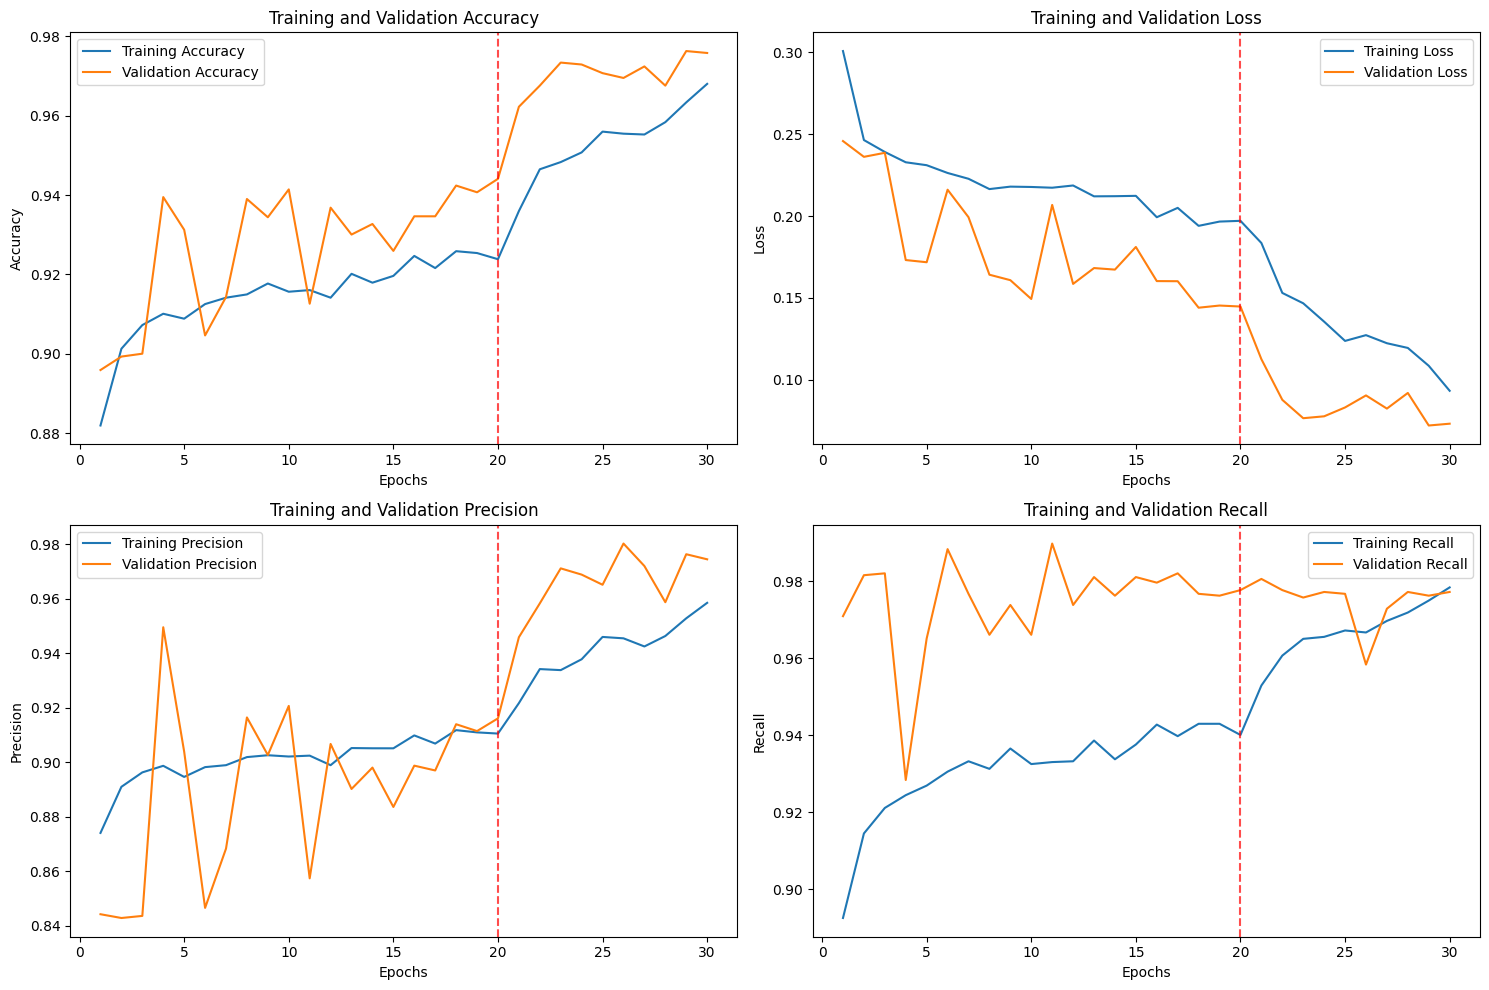

Evaluating model on test set...
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.9648 - loss: 0.0954 - precision: 0.4516 - recall: 0.5029
Test Loss: 0.0737
Test Accuracy: 0.9739
Test Precision: 0.9662
Test Recall: 0.9821
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.98      0.97      0.97      2068
  Uninfected       0.97      0.98      0.97      2068

    accuracy                           0.97      4136
   macro avg       0.97      0.97      0.97      4136
weighted avg       0.97      0.97      0.97      4136



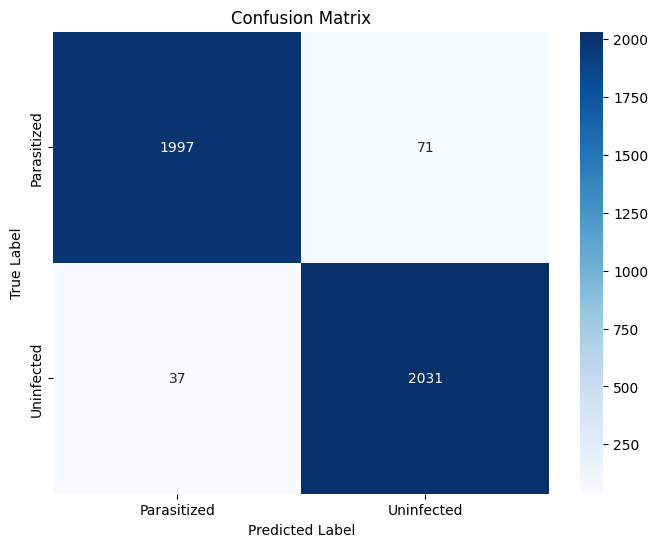

Model saved as 'malaria_diagnosis_resnet50_final.h5'

Training completed successfully!


In [ ]:
# Execute the malaria diagnosis model training
print("Starting Malaria Diagnosis Model Training...")
print("=" * 60)

# Check GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if tf.config.list_physical_devices('GPU'):
    print(f"GPU Device: {tf.test.gpu_device_name()}")

# Parameters
batch_size = 32
img_size = (224, 224)

# Create data generators
train_gen, val_gen, test_gen = create_data_generators(batch_size, img_size)

# Create and compile model
model, base_model = create_resnet_model()
model = compile_model(model, learning_rate=0.001)

print("Phase 1: Feature Extraction")
print("=" * 50)

# Phase 1: Train only the top layers
history1 = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=create_callbacks(),
    verbose=1
)

print("\nPhase 2: Fine-tuning")
print("=" * 50)

# Phase 2: Unfreeze some layers and fine-tune
base_model.trainable = True

# Freeze first 100 layers, unfreeze the rest
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Recompile with lower learning rate
model = compile_model(model, learning_rate=0.0001)

history2 = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=create_callbacks(),
    verbose=1
)

# Plot training history
plot_training_history(history1, history2)

# Evaluate the model
results, predictions = evaluate_model(model, test_gen)

# Save the final model
model.save('malaria_diagnosis_resnet50_final.h5')
print("Model saved as 'malaria_diagnosis_resnet50_final.h5'")

print("\nTraining completed successfully!")